# Building Dataset

In [1]:
from pyimagesearch import config
from imutils import paths
from bs4 import BeautifulSoup
from pyimagesearch.iou import compute_iou

import os
import cv2

In [27]:
# Loop over the output positive and negative directories
for dirPath in (config.POSITVE_PATH, config.NEGATIVE_PATH):
    # If the output directory does not exist yet, create it
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

In [28]:
# grab all image paths in the input images directory
imagePaths = list(paths.list_images(config.ORIG_IMAGES))

In [29]:
# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

In [30]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # show a progress report
    print("[INFO] processing image {}/{}...".format(i + 1,
        len(imagePaths)))

    # extract the filename from the file path and use it to derive
    # the path to the XML annotation file
    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([config.ORIG_ANNOTS,
        "{}.xml".format(filename)])

    # load the annotation file, build the soup, and initialize our
    # list of ground-truth bounding boxes
    contents = open(annotPath).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = []

    # extract the image dimensions
    w = int(soup.find("width").string)
    h = int(soup.find("height").string)

    # loop over all 'object' elements
    for o in soup.find_all("object"):
        # extract the label and bounding box coordinates
        label = o.find("name").string
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)

        # truncate any bounding box coordinates that may fall
        # outside the boundaries of the image
        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)
        
        # update our list of ground-truth bounding boxes
        gtBoxes.append((xMin, yMin, xMax, yMax))

    # load the input image from disk
    image = cv2.imread(imagePath)

    # run selective search on the image and initialize our list of
    # proposed boxes
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects= []

    # loop over the rectangles generated by selective search
    for (x, y, w, h) in rects:
        # convert our bounding boxes from (x, y, w, h) to (startX,
        # startY, startX, endY)
        proposedRects.append((x, y, x + w, y + h))

    # initialize counters used to count the number of positive and
    # negative ROIs saved thus far
    positiveROIs = 0
    negativeROIs = 0

    # loop over the maximum number of region proposals
    for proposedRect in proposedRects[:config.MAX_PROPOSALS]:
        # unpack the proposed rectangle bounding box
        (propStartX, propStartY, propEndX, propEndY) = proposedRect

        # loop over the ground-truth bounding boxes
        for gtBox in gtBoxes:
            # compute the intersection over union between the two
            # boxes and unpack the ground-truth bounding box
            iou = compute_iou(gtBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

            # initialize the ROI and output path
            roi = None
            outputPath = None

            # check to see if the IOU is greater than 70% *and* that
            # we have not hit our positive count limit
            if iou > 0.7 and positiveROIs <= config.MAX_POSITIVE:
                # extract the ROI and then derive the output path to
                # the positive instance
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalPositive)
                outputPath = os.path.sep.join([config.POSITVE_PATH,
                    filename])

                # increment the positive counters
                positiveROIs += 1
                totalPositive += 1

            # determine if the proposed bounding box falls *within*
            # the ground-truth bounding box
            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY

            # check to see if there is not full overlap *and* the IoU
            # is less than 5% *and* we have not hit our negative
            # count limit
            if not fullOverlap and iou < 0.05 and \
                negativeROIs <= config.MAX_NEGATIVE:
                # extract the ROI and then derive the output path to
                # the negative instance
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalNegative)
                outputPath = os.path.sep.join([config.NEGATIVE_PATH,
                    filename])

                # increment the negative counters
                negativeROIs += 1
                totalNegative += 1

            # check to see if both the ROI and output path are valid
            if roi is not None and outputPath is not None:
                # resize the ROI to the input dimensions of the CNN
                # that we'll be fine-tuning, then write the ROI to
                # disk
                roi = cv2.resize(roi, config.INPUT_DIMS,
                    interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

[INFO] processing image 1/200...
[INFO] processing image 2/200...
[INFO] processing image 3/200...
[INFO] processing image 4/200...
[INFO] processing image 5/200...
[INFO] processing image 6/200...
[INFO] processing image 7/200...
[INFO] processing image 8/200...
[INFO] processing image 9/200...
[INFO] processing image 10/200...
[INFO] processing image 11/200...
[INFO] processing image 12/200...
[INFO] processing image 13/200...
[INFO] processing image 14/200...
[INFO] processing image 15/200...
[INFO] processing image 16/200...
[INFO] processing image 17/200...
[INFO] processing image 18/200...
[INFO] processing image 19/200...
[INFO] processing image 20/200...
[INFO] processing image 21/200...
[INFO] processing image 22/200...
[INFO] processing image 23/200...
[INFO] processing image 24/200...
[INFO] processing image 25/200...
[INFO] processing image 26/200...
[INFO] processing image 27/200...
[INFO] processing image 28/200...
[INFO] processing image 29/200...
[INFO] processing image

In [38]:
print('Number of cats:', totalPositive)
print('Number of no_cats:', totalNegative)

Number of cats: 1847
Number of no_cats: 2200


# Fine tune RCNN

In [12]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(config.BASE_PATH))
data = []
labels = []

[INFO] loading images...


In [5]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=config.INPUT_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [6]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
# # perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [9]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [13]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [17]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/5
101/101 [==============================] - 276s 3s/step - loss: 0.1206 - accuracy: 0.9507 - val_loss: 0.0114 - val_accuracy: 0.9963
Epoch 2/5
101/101 [==============================] - 269s 3s/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 3/5
101/101 [==============================] - 283s 3s/step - loss: 0.0062 - accuracy: 0.9988 - val_loss: 0.0043 - val_accuracy: 0.9988
Epoch 4/5
101/101 [==============================] - 268s 3s/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/5
101/101 [==============================] - 315s 3s/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0011 - val_accuracy: 1.0000


In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [19]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [20]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       370
      no_cat       1.00      1.00      1.00       440

    accuracy                           1.00       810
   macro avg       1.00      1.00      1.00       810
weighted avg       1.00      1.00      1.00       810



In [21]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(config.MODEL_PATH, save_format="h5")
# export_saved_model(model, config.MODEL_PATH)

[INFO] saving mask detector model...


In [22]:
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(config.ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label encoder...


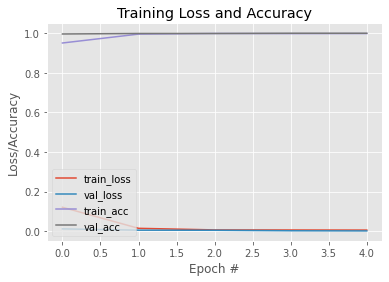

In [23]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

# Detect Object RCNN

In [25]:
from tensorflow.keras.models import load_model
from pyimagesearch.nms import non_max_suppression

import imutils

In [26]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(config.MODEL_PATH)
# model = load_from_saved_model(config.MODEL_PATH, custom_objects={'KerasLayer':hub.KerasLayer})
lb = pickle.loads(open(config.ENCODER_PATH, "rb").read())

[INFO] loading model and label binarizer...


In [27]:
# load the input image from disk
image = cv2.imread('dataset/cat/69.png')
image = imutils.resize(image, width=500)

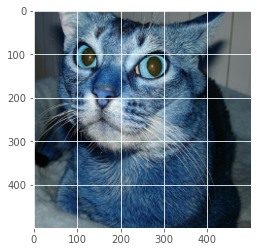

In [28]:
plt.imshow(image);

In [29]:
# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

[INFO] running selective search...


In [63]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

In [64]:
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:config.MAX_PROPOSALS_INFER]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, config.INPUT_DIMS,
		interpolation=cv2.INTER_CUBIC)

	# further preprocess by the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

In [65]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

[INFO] proposal shape: (200, 224, 224, 3)


In [66]:
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

[INFO] classifying proposals...


In [67]:
# find the index of all predictions that are positive for the
# "cat" class
print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == 'cat')[0]

[INFO] applying NMS...


In [68]:
# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "cat" class
boxes = boxes[idxs]
proba = proba[idxs][:, 0]

In [69]:
# further filter indexes by enforcing a minimum prediction
# probability be met
idxs = np.where(proba >= config.MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

In [180]:
# clone the original image so that we can draw on it
clone = image.copy()

In [181]:
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Cat: {:.2f}%".format(prob * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

In [182]:
# show the output after *before* running NMS
cv2.imshow("Before NMS", clone)

In [185]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)

In [186]:
# loop over the bounding box indexes
for i in boxIdxs:
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = boxes[i]
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Cat: {:.2f}%".format(proba[i] * 100)
	cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

In [187]:
# show the output image *after* running NMS
cv2.imshow("After NMS", image)
cv2.waitKey(0)

-1